# Depth Scheduling -- Translation to PyTorch

In this notebook I translate the depth scheduling code in 3_CS_Autoencoder_Depth_Scheduling.ipynb from tensorflow to PyTorch.

To quickly recap the idea and inspiration behind this method. The idea is to mimic, in a neural net, the increasing capacity to learn that a growing of a child's brain recieves in development. As the brain grows, so does its potential to hold a useful mapping. 

This is implemented in a Neural Network by training a small model until it's capacity to fit the data is reach. Then expanding that model by appending new layers to it. Thus increasing the weights of the model while maintaing an understanding of the task developed by the previous layers.

In this notebook, this concept is applied to a simple mnist autoencoder.

In [1]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

Load MNIST for Example

In [28]:
# define the transform
transform = transforms.Compose([
    transforms.ToTensor() # convert to tensor -- automatically scales to [0,1]
])

#get mnist data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#load data
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=512, shuffle=False)

# High Level Overview of the Following Code:
The gist of the code that follows is to first define a shallow autoencoder with a specified latent space dimmension. This Autoencoder is trained, then updated. The update involves appending a new layer on top of the encoder output and, inversely, appending a new layer to the begging of the decoder. The new encoder layer outputs a smaller vector than it inputs. The new decoder layer takes this smaller dim vector as input and subsequently grows it back to the initial decoders input size. Then training is repeated. Thus, the autoencoder grows in depth while retaining some of its previous understanding. This is repeated until the presecified number of layers has been attained.

It might be fair to say this algorithm is a version of gridsearch for the number of layers. With the added plus of training time being reduced by taking adavantage of the computation that already went into training the previous search.

# How the Autoencoder is Constructed
The following class definitions are used to construct the AE. Both initially, and during a depth update. The structure is relatively simple. 

If an old model has been passed to the encoder/decoder, append the new layer in the appropriate location. If the old_model is None, construct the initial model's input. 

The latent dimmension, latent, remains constant in this implementation. 

The autoencoder class then combines the encoder and the decoder in its forward pass

In [29]:
class encoder(nn.Module):
    def __init__(self, old_model, latent=100):
        super(encoder, self).__init__()
        self.flatten_input = nn.Flatten() 
        self.to_latent = nn.Linear(28*28, latent) #recieves 28*28 dim vector, outputs neuron dim vector
        self.hidden_layer = nn.Linear(latent, latent) 
        self.old_model = old_model

    def forward(self, x):
        if self.old_model is not None: # expand upon old model
            x = self.old_model(x)
        elif self.old_model is None: 
            x = self.flatten_input(x) #create initial layer to flatten digit
            x = self.to_latent(x) # and downscale to the latent space
    
        x = F.relu(self.hidden_layer(x))  #add new hidden with relu
        return x

class decoder(nn.Module):
    def __init__(self, old_model, latent=100):
        super(decoder, self).__init__()
        self.hidden_layer = nn.Linear(latent, latent) #recieves neuron dim vector, outputs neuron dim vector
        self.output_layer = nn.Linear(latent, 28*28) 
        self.unflatten_output = nn.Unflatten(1, (1, 28, 28))

        self.old_model = old_model # if old model is not none, then we expand upon it

    def forward(self, x):
        x = F.relu(self.hidden_layer(x))  #add new hidden layer with relu

        if self.old_model is not None: 
            x = self.old_model(x) # pass through old model

        elif self.old_model is None: # if no old model, then we define the model output
            x = self.output_layer(x) # --> og num pix
            x = self.unflatten_output(x) # --> original shape

        return x
    
class autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x): #combine encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)

        x = torch.sigmoid(x)  #sigmoid activation to get values between 0 and 1 for BCE
        return x

This function defines the training loop for each iteration of the model. It uses early stopping regularization to determine the number of epochs. The final training and test loss are returned in a list after being returned from the evaluate() function. evaluate() is defined next.

In [30]:
def train_model(model, optimizer, criterion, epochs=100, early_stopping_patience=100, device="cpu"):
    #initialize early stopping params
    patience, counter, min_loss = early_stopping_patience, 0, np.Inf
    
    #Training Loop
    for epoch in range(epochs):
        for i, data in enumerate(train_loader): #get batch 
            inputs = data[0].to(device) #get images from (feature, target) send --> device
            output = model(inputs) #forward pass
            loss = criterion(output, inputs) #calculate loss

            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagate gradients
            optimizer.step()  # Update the weights

        loss = evaluate(model, criterion, device, do_train_loss=False) #returns list [test_loss, None]
        if epoch % 10 == 0:
            print(f'Epoch: {epoch} \tTest Loss: {loss[0]:.8f}')
        test_loss = loss[0]
         
        #early stopping
        if test_loss < min_loss: #if test loss decreases
            min_loss = test_loss #update min loss
            counter = 0 #reset if loss decreases
        else:
            counter += 1
            if counter >= patience: #stop if loss doesn't decrease for patience epochs
                print(f'\nEarly stopping at epoch: {epoch} \nFinal Loss on test set was {test_loss:.8f}\n')
                break
        

    final_loss = evaluate(model, criterion, device, do_train_loss=True) #returns list [test_loss, train_loss]
    print(f'Test Loss: {final_loss[0]:.4f} \nTrain Loss: {final_loss[1]:.4f}')  
    
    return model, final_loss


update_model() is used to strip out the encoder and decoder from the old_model. If the model is empty, a None object will be passed to the encoder decoder classes which will handel the creation of a new model. If the old model exists, the encoder and decoder are passed to the encoder decoder classes which will add new layers to each model at the innermost part of the network. The new autoencoder is then returned.

In [31]:
def update_model(latent, old_model):
    '''
    update model with new encoder and decoder
    if old_model is None, initialize new model
    '''
    
    #seperate encoder and decoder frpm old model
    if old_model is not None:
        old_encoder = old_model.encoder
        old_decoder = old_model.decoder
    elif old_model is None:
        old_encoder, old_decoder = None, None #initialize to none if no old model

    encoder_instance = encoder(old_encoder, latent=latent)
    decoder_instance = decoder(old_decoder, latent=latent)
    return autoencoder(encoder=encoder_instance, decoder=decoder_instance)


evaluate() is used to evaluate the model on the test and train set. If do_train_loss is False, it only evals the test set. This is to save compute during training. If set to true, it evals on both sets and returns both.


In [32]:
def evaluate(model, criterion, device, do_train_loss=False):
    '''
    compute loss on test and train sets
    '''
    model.eval() #turn off gradient calculation

    with torch.no_grad(): #turn off gradient calculation

        #calculate loss on test set
        loss_sum = 0 #initialize loss
        for data in test_loader: #calculate loss for each batch
            data[0].to(device) #send images to device
            outputs = model(data[0])
            loss_sum += criterion(outputs, data[0]) #add loss to loss sum
        test_loss = loss_sum / len(test_loader) #average loss over all batches

        if do_train_loss:
            #calculate loss on the train set
            loss_sum = 0 #initialize loss
            for data in train_loader: #calculate loss for each batch
                data[0].to(device)
                images, labels = data
                outputs = model(images)
                loss_sum += criterion(outputs, data[0]) #add loss to loss sum
            train_loss = loss_sum / len(train_loader) #average loss over all batches

    model.train() #turn gradient calculation back on


    if do_train_loss: #return train loss if specified
        output = [test_loss.item(), train_loss.item()]
    else:
        output = [test_loss.item(), None] #return test loss only but keep same shape as output with None

    return output

This is the master function that controls this entire operation. 

First, a history dictionary is defined to track performance after each training session. 

Then a for loop begins that will run for the num final layers specified for the autoencoder. A model is created using update_model() and is then trained using train_model(). The loss is computed, stored, and logged to terminal. After the loop repeats, the model is updated with update_model(), this time being fed the previous model as argument for training.

The model, history are returned.

In [33]:
def depth_scheduling(layers_to_train, latent, criterion, device="cpu"):
    print(f'Beginning training for {layers_to_train} layers \n{latent} dimmension latent space \nUsing {device} \n')

    history = {} #initialize performance history dict and model

    for i in range(layers_to_train): #for specified num layers

        if i == 0: #if first layer create initial model with old_model=None
            print(f'Creating initial model with {i+1} depth and {latent} dim latent space')
            model = update_model(latent=latent, old_model=None)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #initialize optimizer with new parameters
        else: #update model
            print(f'\nUpdating model with {i+1} depth and {latent} dim latent space')
            model = update_model(latent=latent, old_model=model) #create initial model or update model with new encoder and decoder
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #initialize optimizer with new parameters

        model, loss = train_model(model, optimizer, criterion) #train

        #evaluate model
        history[i] = loss
        

    return history, model

In [34]:
def check_cuda():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("Running on the GPU")
    else:
        device = torch.device("cpu")
        print("Running on the CPU")
    return device

# Running the Depth Scheduling Algorithm

In [35]:
criterion = nn.MSELoss() 

device = check_cuda()

history, model = depth_scheduling(layers_to_train=5, latent=10, criterion=criterion , device=device)

Running on the GPU
Beginning training for 5 layers 
10 dimmension latent space 
Using cuda:0 

Creating initial model with 1 depth and 10 dim latent space
Epoch: 0 	Test Loss: 0.08207840
Epoch: 10 	Test Loss: 0.04322938
Epoch: 20 	Test Loss: 0.03585443
Epoch: 30 	Test Loss: 0.03485011
Epoch: 40 	Test Loss: 0.03437874
Epoch: 50 	Test Loss: 0.03407008
Epoch: 60 	Test Loss: 0.03383536
Epoch: 70 	Test Loss: 0.03358372
Epoch: 80 	Test Loss: 0.03333703
Epoch: 90 	Test Loss: 0.03308956
Test Loss: 0.0329 
Train Loss: 0.0333

Updating model with 2 depth and 10 dim latent space
Epoch: 0 	Test Loss: 0.05188194
Epoch: 10 	Test Loss: 0.03498093
Epoch: 20 	Test Loss: 0.03455301
Epoch: 30 	Test Loss: 0.03430707
Epoch: 40 	Test Loss: 0.03419394
Epoch: 50 	Test Loss: 0.03401396
Epoch: 60 	Test Loss: 0.03385875
Epoch: 70 	Test Loss: 0.03239619
Epoch: 80 	Test Loss: 0.03181084
Epoch: 90 	Test Loss: 0.03167626
Test Loss: 0.0316 
Train Loss: 0.0319

Updating model with 3 depth and 10 dim latent space
Epoch

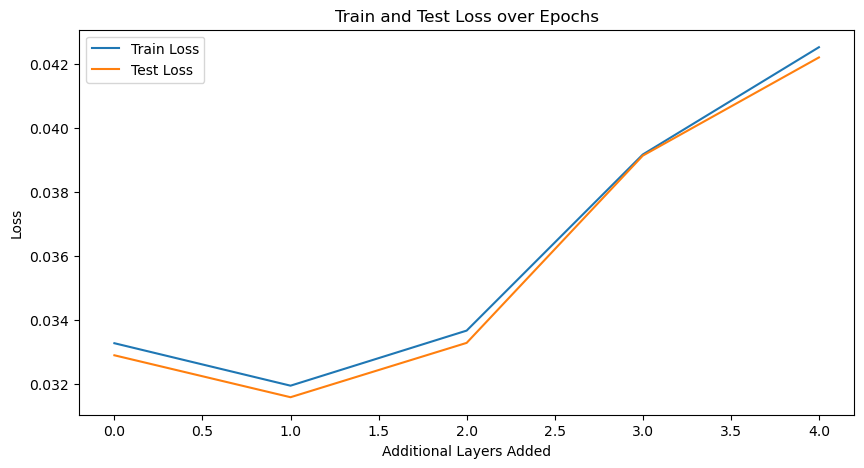

In [37]:
#get historical loss's of autoencoder with dif depths
test_losses = [values[0] for values in history.values()]
train_losses = [values[1] for values in history.values()]

plt.figure(figsize=(10, 5))

# Plot train loss
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')

# Plot test loss
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')

plt.title('Train and Test Loss over Epochs')
plt.xlabel('Additional Layers Added')
plt.ylabel('Loss')
plt.legend()

plt.show()


The plot above illustrates a potential benefit of this method. It acts as a sort of grid search of number of layers while taking advantage of the compute that already went into the other versions.

The plot shows that for 100 epochs, the model with only one added layer performed the best. This is the model that performed best on the underfitting/overfitting tradeoff. At 2+ added layers, the performance begins to decline. The test loss also begins to climb up from its position under the train loss. However, this doesn't take into account any regularization techniques that might be used to offset performance decline with additional layers.

Below is a printout of the final model

In [38]:
print(model)

autoencoder(
  (encoder): encoder(
    (flatten_input): Flatten(start_dim=1, end_dim=-1)
    (to_latent): Linear(in_features=784, out_features=10, bias=True)
    (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
    (old_model): encoder(
      (flatten_input): Flatten(start_dim=1, end_dim=-1)
      (to_latent): Linear(in_features=784, out_features=10, bias=True)
      (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
      (old_model): encoder(
        (flatten_input): Flatten(start_dim=1, end_dim=-1)
        (to_latent): Linear(in_features=784, out_features=10, bias=True)
        (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
        (old_model): encoder(
          (flatten_input): Flatten(start_dim=1, end_dim=-1)
          (to_latent): Linear(in_features=784, out_features=10, bias=True)
          (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
          (old_model): encoder(
            (flatten_input): Flatten(